<a href="https://colab.research.google.com/github/prefecttai/Eucalyptus-Classification/blob/main/699_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [ ]:
install.packages("FSelector")
install.packages("e1071")
install.packages("caret")
install.packages('glmnet')
install.packages("caTools")
install.packages("class")
install.packages("randomForest")
install.packages("RRF")
install.packages("mlbench")
install.packages("pROC")
install.packages("MLmetrics")
install.packages("kernlab")
install.packages("ggplot2")

# Call library() packages

In [ ]:
library(rpart)
library(FSelector)
library(dplyr)
library(e1071)
library(caret)
library(mlbench)
library(glmnet)
library(class)
library(caTools)
library(randomForest)
library(RRF)
library(pROC)
library(MLmetrics)
library(kernlab)
library(ggplot2)

# Read dataset & rename columns

In [ ]:
#@title
#Read Data
set.seed(699)
eucalyptus <- read.csv("eucalyptus.csv")
nrow(eucalyptus)
ncol(eucalyptus)
colnames(eucalyptus) = c("Abbrev","Rep","Locality","Map_Ref","Latitude","Altitude","Rainfall","Frosts","Year","Sp","PMCno","DBH","Ht","Surv","Vig","Ins_res","Stem_Fm","Crown_Fm","Brnch_Fm","Utility")
head(eucalyptus)

[1] 736

[1] 20

,Abbrev,Rep,Locality,Map_Ref,Latitude,Altitude,Rainfall,Frosts,Year,Sp,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm,Utility
,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,co,1520,18.45,9.96,40,4,3,3.5,4,3.5,good
2,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,fr,1487,13.15,9.65,90,4.5,4,3.5,3.5,3,best
3,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,ma,1362,10.32,6.5,50,2.3,2.5,3,3.5,3,low
4,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,nd,1596,14.8,9.48,70,3.7,3,3.3,4,3.5,good
5,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,ni,2088,14.5,10.78,90,4,2.7,3.3,3,3,good
6,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,ob,1522,17.01,12.28,70,5,4,5,4,4.5,best


# Data Cleaning

In [ ]:
#@title Check for ? & convert to NA and count NAs { display-mode: "form" }
#@title
#Set all ? to NA for removal
set.seed(699)
eucalyptus[eucalyptus == '?'] = NA
#Test the number of missing value
sapply(eucalyptus,function(x)sum(is.na(x)))

Abbrev      Rep Locality  Map_Ref Latitude Altitude Rainfall   Frosts 
       0        0        0        0        0        0        0        0 
    Year       Sp    PMCno      DBH       Ht     Surv      Vig  Ins_res 
       0        0        7        1        1       94       69       69 
 Stem_Fm Crown_Fm Brnch_Fm  Utility 
      69       69       69        0

In [ ]:
#@title Delete NAs { display-mode: "form" }
#Delete rows with null values
set.seed(699)
data <- na.omit(eucalyptus)
nrow(data)

[1] 641

In [ ]:
#@title Clean data and Convert attribute types
set.seed(699)
data <- data.frame(unclass(data), stringsAsFactors = TRUE)
#(1)drop levels that has 0 entries, due to omit na
data$Locality <- droplevels(data$Locality)
data$Abbrev <- droplevels(data$Abbrev)
data$Sp <- droplevels(data$Sp)
data$PMCno <- droplevels(data$PMCno)
data$Surv <- droplevels(data$Surv)
data$Vig <- droplevels(data$Vig)
data$Ins_res <- droplevels(data$Ins_res)
data$Stem_Fm <- droplevels(data$Stem_Fm)
data$Crown_Fm <- droplevels(data$Crown_Fm)
data$Brnch_Fm <- droplevels(data$Brnch_Fm)
#(2)drop columns Rep and Latitude using subset()
data <- subset(data, select = -c(Rep,Latitude))
#(3)convert Year to factor
data$Year <- factor(data$Year)
#(4)convert attributes to numeric variables
data$Ht <- as.numeric(as.character(data$Ht))
data$DBH <- as.numeric(as.character(data$DBH))
data$Stem_Fm = as.numeric(as.character(data$Stem_Fm))
data$Crown_Fm = as.numeric(as.character(data$Crown_Fm))
data$Brnch_Fm = as.numeric(as.character(data$Brnch_Fm))
data$Surv <- as.numeric(as.character(data$Surv))
data$Vig = as.numeric(as.character(data$Vig))
data$Ins_res = as.numeric(as.character(data$Ins_res))
#(5)convert Utility colnames to class
colnames(data)[which(names(data) == "Utility")] <- "class"
#(6)remove entry where PMCno=1
data = subset(data, data$PMCno != 1)
summary(data)

     Abbrev                             Locality           Map_Ref   
 Puk    : 84   Central_Hawkes_Bay           : 30   N158_344/626:143  
 Wak    : 73   Central_Hawkes_Bay_(coastal) : 70   N166_063/197: 84  
 Wai    : 70   Central_Wairarapa            :188   N162_081/300: 73  
 K81    : 64   South_Wairarapa              :210   N142_377/957: 70  
 WSp    : 59   Southern_Hawkes_Bay          : 85   N151_912/221: 59  
 Paw    : 55   Southern_Hawkes_Bay_(coastal): 55   N146_273/737: 55  
 (Other):233                                       (Other)     :154  
    Altitude        Rainfall        Frosts         Year           Sp     
 Min.   : 70.0   Min.   : 850   Min.   :-3.000   1980: 52   re     : 81  
 1st Qu.:150.0   1st Qu.:1000   1st Qu.:-3.000   1981:240   nd     : 67  
 Median :180.0   Median :1080   Median :-3.000   1982:129   ov     : 59  
 Mean   :173.4   Mean   :1098   Mean   :-2.668   1983:217   fa     : 52  
 3rd Qu.:180.0   3rd Qu.:1200   3rd Qu.:-2.000              fr     : 4

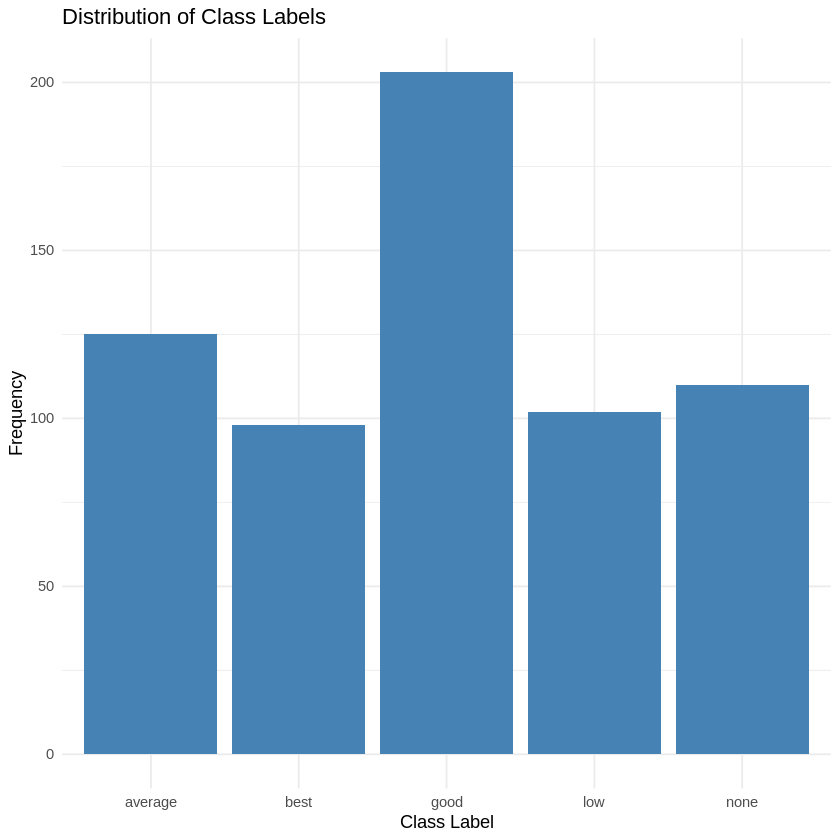

In [ ]:
#@title Data Visualization
ggplot(data, aes(x = class)) + geom_bar(fill = "steelblue") + theme_minimal() +
  labs(x = "Class Label", y = "Frequency", title = "Distribution of Class Labels")

# Data Visualization

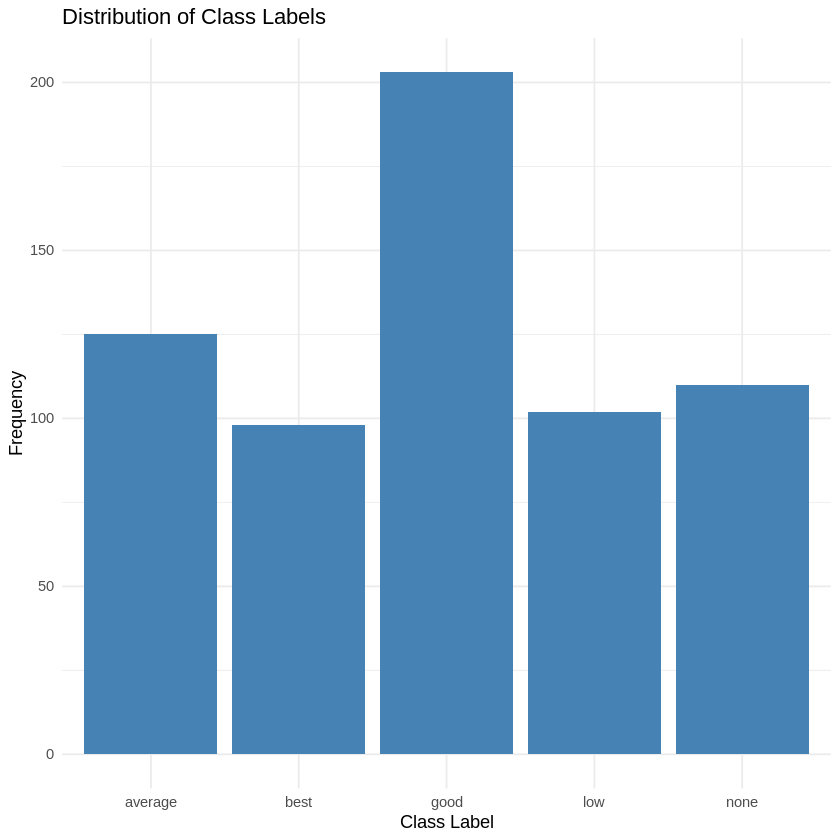

In [ ]:
ggplot(data, aes(x = class)) + geom_bar(fill = "steelblue") + theme_minimal() +
  labs(x = "Class Label", y = "Frequency", title = "Distribution of Class Labels")

# Attribute Names & Definitions

---
*   Abbrev: Site Abbreviation (Cly=Clydebank, Cra=Craggy Range Road, ...)
*   Rep: Number of Experimental Replications
*   Locality: Site location in North Island (Central Hawkes Bay, Northern Hawkes Bay, ...)
*   Map_Ref: Map Location in North Island
*   Latitude: Latitude Approximation South(degrees__minutes) -> South(39__38)
*   Altitude: Unit (m)
*   Rainfall:  Unit (mm pa)
*   Frosts: Unit (Degrees C)
*   Year: Year of Planting
*   Sp: Species (Enumerated)
*   PMCno: Seedlot Number, a unique number for specific species with specific quantity and quality
*   DBH: Diameter at Breast Height, Unit (cm)
*   Ht: Height, Unit (m)
*   Surv: Survival Percentage
*   Vig: Vigour(Health and Resilience)
*   Ins_res: Insect Resistance
*   Stem_Fm: Stem Form
*   Crown_Fm: Crown Form
*   Brnch_Fm: Branch Form
*   Utility: Determined by None, Low, Average, Good, Best









# Split dataset into train and test sets

In [ ]:
#Split the dataset into a training dataset and a test dataset
set.seed(699)
data$Locality = as.integer(data$Locality)
data[3,]
data[30,]
data[31,]
tr_idx <- sample(dim(data)[1], dim(data)[1]*0.66)
train <- data[tr_idx, ]
test <- data[-tr_idx, ]

,Abbrev,Locality,Map_Ref,Altitude,Rainfall,Frosts,Year,Sp,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm,class
,<fct>,<int>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,Cra,1,N135_382/137,100,850,-2,1980,ma,1362,10.32,6.5,50,2.3,2.5,3,3.5,3,low


,Abbrev,Locality,Map_Ref,Altitude,Rainfall,Frosts,Year,Sp,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm,class
,<fct>,<int>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
30,Cra,1,N135_382/137,100,850,-2,1980,si,1525,14.75,7.79,30,4,4,4,2.5,2,good


,Abbrev,Locality,Map_Ref,Altitude,Rainfall,Frosts,Year,Sp,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm,class
,<fct>,<int>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
31,Nga,5,N145_874/586,130,1000,-3,1980,co,1520,10.1,8.2,60,3,4,3.5,3.5,3.2,average


# Attribute Selection Methods

In [ ]:
#@title Chi-Square Test { vertical-output: true }
# Using Attribute Selection Method: Chi-Square Test
Feat_Sel_CHI_SQR <- function(train) {
    weighted = chi.squared(class~., train)
    barplot(t(as.matrix(weighted)), las = 3)
    # Cut off point
    attr_subset = cutoff.biggest.diff(weighted)
    # Reduced training dataset
    subset = train %>% select(attr_subset)
    subset$Utility = train$Utility
    return(subset)
}

In [ ]:
#@title Learning Vector Quantization (L.V.Q.) { display-mode: "form" }
# Using Attribute Selection Method: Rank Features by Importance using L.V.Q.
Feat_Sel_LVQ <- function(train){
    suppressWarnings({
    ctrl = trainControl(method = "repeatedcv", number = 10, repeats = 3)
    model = train(class ~., data = train, method = "lvq", preProcess = "scale", trControl = ctrl)
    imp = varImp(model, scale = FALSE)
    imp_matrix = as.matrix(imp$importance)
    # Get Average Scores for each possible class outcome per variable
    avg_scores = rowMeans(imp_matrix[, 1:5])
    # Set Cutoff to be 0.7
    cutoff = 0.7
    sel_var = rownames(subset(imp_matrix, avg_scores >= cutoff))
    subset = train[sel_var]
    return(subset)
    })
}

In [ ]:
#@title Recursive Feature Elimination (R.F.E.)
# R.F.E. cannot handle categorical predictors with more than 53 categories, Drop all attributes that have more than 53 levels
Feat_Sel_RFE <- function(train){
    red_train = subset(train, select = -c(Abbrev, Map_Ref, PMCno, Sp))
    # Using Attribute Selection Method: Recursive Feature Elimination (R.F.E.)
    ctrl = rfeControl(functions = rfFuncs, method = "cv", number = 10)
    results = rfe(red_train[,1:(ncol(red_train) - 1)], red_train[,ncol(red_train)], sizes = c(1:(ncol(red_train) - 1)), rfeControl = ctrl)
    subset = train[predictors(results)]
    return (subset)
}

In [ ]:
#@title Random Forest Importance (R.F.I.)
# Random Forest cannot handle categorical predictors with more than 53 categories
# Drop all attributes that have more than 53 levels
Feat_Sel_RFI <- function(train){
    drop_train = subset(train, select = -c(PMCno))
    rf.model = random.forest.importance(class ~., data = drop_train)
    rf.model.sub = subset(rf.model, rf.model$attr_importance > 20)
    subset = train[rownames(rf.model.sub)]
    return (subset)
}

In [ ]:
#@title Information Gain
Feat_Sel_IG <- function(train){
    result = information.gain(class ~., data = train)
    cut_off = quantile(result$attr_importance, 0.7)
    sel_var = subset(result, result$attr_importance >= cut_off)
    subset = train[rownames(sel_var)]
    return (subset)
}


# ROC and MCC Calculations

In [ ]:
#@title Calculate ROC
ROC <- function(model, test){
    pos.class.prob = predict(model, test, type = "prob")
  num_classes = length(unique(test$class))
  auc_val = numeric(num_classes)
  for(i in seq_along(unique(test$class))){
    curr_class = as.numeric(test$class == unique(test$class)[i])
    roc.obj = roc(curr_class, pos.class.prob[, i])
    auc_val[i] = auc(roc.obj)
  }
  return (auc_val)
}

In [ ]:
#@title Calculate ROC for Naive Bayes
ROC.nb <-function(model, test){
    pos.class.prob = predict(model, test, type = "raw")
    multi.roc = multiclass.roc(test$class, pos.class.prob)
    auc_val = length(5)
    for(i in seq_along(multi.roc$levels)){
        curr_class = test$class == multi.roc$levels[i]
        else_class = !curr_class
        roc.obj = roc(curr_class, pos.class.prob[, i])
        auc_val[i] = auc(roc.obj)
    }
    print(multi.roc$rocs)
    return (auc_val)
}

In [ ]:
#@title Calculate MCC
MCC_List <- function(perf.mea) {
    mcc.val = ncol(perf.mea$table)
    for(x in 1:nrow(perf.mea$table)){
        tp = perf.mea$table[x, x]
        fp = sum(perf.mea$table[-x, x])
        fn = sum(perf.mea$table[x, -x])
        tn = sum(perf.mea$table[-x, -x])
        mcc.val[x] = mcc(tp, fp, tn, fn)
    }
    return (mcc.val)
}
mcc <- function(tp, fp, tn, fn){
  (tp * tn - fp * fn) / sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
}


#10-fold cross-validation

In [ ]:
set.seed(699)
# repeat 10-fold cross-validation 5 times
train_control <- trainControl(method = "repeatedcv", number = 10, repeats = 5,
                              summaryFunction = defaultSummary)

# Naive Bayes Model

In [ ]:
set.seed(699)
# Attribute Selection:
#attr_subset = Feat_Sel_CHI_SQR(train)
#attr_subset = Feat_Sel_LVQ(train)
#attr_subset = Feat_Sel_RFE(train)
#attr_subset = Feat_Sel_RFI(train)
attr_subset = Feat_Sel_IG(train)
# build a Naïve Bayes model from training dataset
train_nb = attr_subset
test_nb = test[colnames(attr_subset)]
test_nb$class = test$class
model_nb <- naiveBayes(train$class ~ ., data = train_nb)
# test on test model
NB_test <- predict(model_nb, newdata = test_nb, type = "class", trControl = train_control)
# produce performance measures
perf.mea <- confusionMatrix(NB_test, test$class)
perf.mea
TP.rate = perf.mea$byClass[,1] # Sensitivity
FP.rate = 1 - perf.mea$byClass[,2] # Specificity
Prec = perf.mea$byClass[,3]
Recall = TP.rate
F.meas = 2 * (Prec * Recall) / (Prec + Recall)
print(TP.rate)
print(FP.rate)
print(Prec)
print(Recall)
print(F.meas)
print(ROC.nb(model_nb, test_nb))
print(MCC_List(perf.mea))

Confusion Matrix and Statistics

          Reference
Prediction average best good low none
   average      20    3   20   6    1
   best          0    0    0   0    0
   good         13   40   52   2    2
   low           8    2    2  12    4
   none          3    0    1   5   21

Overall Statistics
                                          
               Accuracy : 0.4839          
                 95% CI : (0.4157, 0.5525)
    No Information Rate : 0.3456          
    P-Value [Acc > NIR] : 1.894e-05       
                                          
                  Kappa : 0.309           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: average Class: best Class: good Class: low
Sensitivity                 0.45455      0.0000      0.6933     0.4800
Specificity                 0.82659      1.0000      0.5986     0.9167
Pos Pred Value              0.40000         NaN      0.4771     0.4286
Neg P

Class: average    Class: best    Class: good     Class: low    Class: none 
     0.4545455      0.0000000      0.6933333      0.4800000      0.7500000 
Class: average    Class: best    Class: good     Class: low    Class: none 
    0.17341040     0.00000000     0.40140845     0.08333333     0.04761905 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.4000000            NaN      0.4770642      0.4285714      0.7000000 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.4545455      0.0000000      0.6933333      0.4800000      0.7500000 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.4255319            NaN      0.5652174      0.4528302      0.7241379 


Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



$`average/best`
$`average/best`[[1]]

Call:
roc.default(response = classes, predictor = predictor, levels = levels,     percent = percent, direction = direction, auc = FALSE, ci = FALSE)

Data: predictor in 44 controls (classes 1) > 45 cases (classes 2).
Area under the curve not computed.

$`average/best`[[2]]

Call:
roc.default(response = classes, predictor = predictor, levels = levels,     percent = percent, direction = direction, auc = FALSE, ci = FALSE)

Data: predictor in 45 controls (classes 2) > 44 cases (classes 1).
Area under the curve not computed.


$`average/good`
$`average/good`[[1]]

Call:
roc.default(response = classes, predictor = predictor, levels = levels,     percent = percent, direction = direction, auc = FALSE, ci = FALSE)

Data: predictor in 44 controls (classes 1) > 75 cases (classes 2).
Area under the curve not computed.

$`average/good`[[2]]

Call:
roc.default(response = classes, predictor = predictor, levels = levels,     percent = percent, direction = directi

#KNN Model

k-Nearest Neighbors 

421 samples
  4 predictor
  5 classes: 'average', 'best', 'good', 'low', 'none' 

Pre-processing: centered (4), scaled (4) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 378, 380, 378, 379, 381, 377, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    5  0.5530251  0.4238995
    7  0.5702609  0.4436521
    9  0.5682447  0.4398133
   11  0.5715792  0.4442934
   13  0.5615188  0.4303739
   15  0.5635487  0.4322172
   17  0.5691859  0.4383394
   19  0.5654423  0.4336921
   21  0.5777813  0.4493979
   23  0.5679505  0.4365346
   25  0.5686334  0.4365353
   27  0.5790880  0.4496238
   29  0.5790060  0.4494007
   31  0.5749252  0.4433640
   33  0.5748997  0.4426568
   35  0.5734401  0.4402130
   37  0.5696506  0.4339918
   39  0.5697508  0.4338783
   41  0.5625857  0.4238090
   43  0.5611545  0.4222143
   45  0.5630271  0.4245433
   47  0.5602148  0.4207235
   49  0.5620525  0.4225223
   51  0.5582736  0

Confusion Matrix and Statistics

          Reference
Prediction average best good low none
   average      17    3   11   5    2
   best          0   11    0   0    0
   good         12   31   61   0    2
   low          15    0    3  14    4
   none          0    0    0   6   20

Overall Statistics
                                          
               Accuracy : 0.5668          
                 95% CI : (0.4981, 0.6337)
    No Information Rate : 0.3456          
    P-Value [Acc > NIR] : 2.35e-11        
                                          
                  Kappa : 0.4229          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: average Class: best Class: good Class: low
Sensitivity                 0.38636     0.24444      0.8133    0.56000
Specificity                 0.87861     1.00000      0.6831    0.88542
Pos Pred Value              0.44737     1.00000      0.5755    0.38889
Neg P

Class: average    Class: best    Class: good     Class: low    Class: none 
     0.3863636      0.2444444      0.8133333      0.5600000      0.7142857 
Class: average    Class: best    Class: good     Class: low    Class: none 
    0.12138728     0.00000000     0.31690141     0.11458333     0.03174603 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.4473684      1.0000000      0.5754717      0.3888889      0.7692308 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.3863636      0.2444444      0.8133333      0.5600000      0.7142857 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.4146341      0.3928571      0.6740331      0.4590164      0.7407407 


Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 0.4883099 0.8173127 0.6171834 0.7933673 0.7929167
[1] 0.2803097 0.4517734 0.4723023 0.3822932 0.7045867


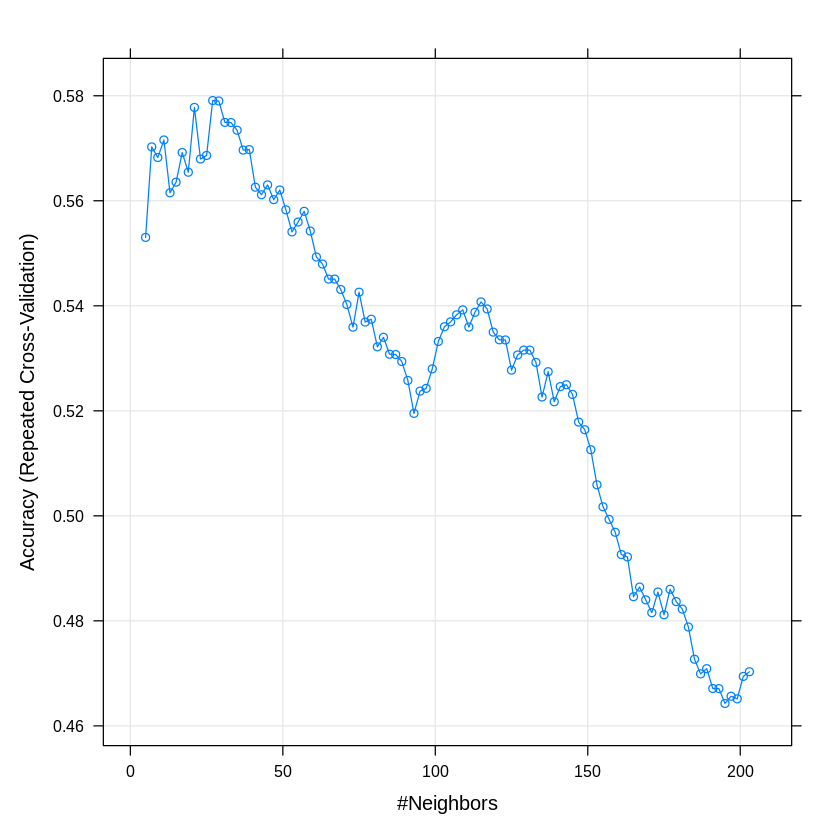

In [ ]:
# Attribute Selection:
suppressWarnings({
#attr_subset = Feat_Sel_CHI_SQR(train)
attr_subset = Feat_Sel_LVQ(train)
#attr_subset = Feat_Sel_RFE(train)
#attr_subset = Feat_Sel_RFI(train)
#attr_subset = Feat_Sel_IG(train)
train_KNN = attr_subset
train_KNN$class = train$class
test_KNN = test[colnames(attr_subset)]
test_KNN$class = test$class
## KNN
knnModel <- train(class ~., data = train_KNN , method = "knn",
                    trControl=train_control,
                    preProcess = c("center", "scale"),
                    tuneLength = 100)
})
knnModel
plot(knnModel)
KNN_test <- predict(knnModel, newdata = test_KNN)
perf.mea <- confusionMatrix(KNN_test, test$class)
perf.mea
TP.rate = perf.mea$byClass[,1] # Sensitivity
FP.rate = 1 - perf.mea$byClass[,2] # Specificity
Prec = perf.mea$byClass[,3]
Recall = TP.rate
F.meas = 2 * (Prec * Recall) / (Prec + Recall)
print(TP.rate)
print(FP.rate)
print(Prec)
print(Recall)
print(F.meas)
print(ROC(knnModel, test_KNN))
print(MCC_List(perf.mea))

#J48 Model


In [ ]:
set.seed(699)
# Attribute Selection:
#attr_subset = Feat_Sel_CHI_SQR(train)
attr_subset = Feat_Sel_LVQ(train)
#attr_subset = Feat_Sel_RFE(train)
#attr_subset = Feat_Sel_RFI(train)
#attr_subset = Feat_Sel_IG(train)
train_j48 = attr_subset
train_j48$class = train$class
test_j48 = test[colnames(attr_subset)]
test_j48$class = test$class
train_control <- trainControl(method = "repeatedcv", number = 10, repeats = 5,
                              summaryFunction = defaultSummary)
J48Grid <-  expand.grid(C = c(0.01, 0.25, 0.5), M = (1:4))
model_j48 <- train(class ~ ., data = train_j48 , method = "J48", trControl = train_control, tuneGrid = J48Grid)
model_j48
plot(model_j48)
J48_test <- predict(model_j48, newdata = test_j48)
perf.mea <- confusionMatrix(J48_test, test$class)
perf.mea
TP.rate = perf.mea$byClass[,1] # Sensitivity
FP.rate = 1 - perf.mea$byClass[,2] # Specificity
Prec = perf.mea$byClass[,3]
Recall = TP.rate
F.meas = 2 * (Prec * Recall) / (Prec + Recall)
print(TP.rate)
print(FP.rate)
print(Prec)
print(Recall)
print(F.meas)
print(ROC(model_j48, test_j48))
print(MCC_List(perf.mea))

#rpart Decision Tree Model

,model,parameter,label,forReg,forClass,probModel
,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
1,rpart,cp,Complexity Parameter,TRUE,TRUE,TRUE


CART 

421 samples
  5 predictor
  5 classes: 'average', 'best', 'good', 'low', 'none' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 379, 378, 380, 379, 377, 380, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa    
  0.006825939  0.5394101  0.3999522
  0.007963595  0.5365092  0.3955316
  0.008191126  0.5365092  0.3955316
  0.008532423  0.5365092  0.3955316
  0.013651877  0.5254690  0.3817661
  0.020477816  0.5150422  0.3651193
  0.027303754  0.4955087  0.3322025
  0.030716724  0.4932814  0.3219662
  0.109215017  0.4521907  0.2492944
  0.204778157  0.4052999  0.1717331

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.006825939.

Confusion Matrix and Statistics

          Reference
Prediction average best good low none
   average      16    1    7   5    0
   best          2    9    9   0    0
   good         17   32   54   2    3
   low           9    0    3  10    3
   none          0    3    2   8   22

Overall Statistics
                                          
               Accuracy : 0.5115          
                 95% CI : (0.4429, 0.5798)
    No Information Rate : 0.3456          
    P-Value [Acc > NIR] : 3.874e-07       
                                          
                  Kappa : 0.3467          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: average Class: best Class: good Class: low
Sensitivity                 0.36364     0.20000      0.7200    0.40000
Specificity                 0.92486     0.93605      0.6197    0.92188
Pos Pred Value              0.55172     0.45000      0.5000    0.40000
Neg P

Class: average    Class: best    Class: good     Class: low    Class: none 
     0.3636364      0.2000000      0.7200000      0.4000000      0.7857143 
Class: average    Class: best    Class: good     Class: low    Class: none 
    0.07514451     0.06395349     0.38028169     0.07812500     0.06878307 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.5517241      0.4500000      0.5000000      0.4000000      0.6285714 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.3636364      0.2000000      0.7200000      0.4000000      0.7857143 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.4383562      0.2769231      0.5901639      0.4000000      0.6984127 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 0.5625352 0.7801680 0.5592486 0.7020975 0.7283333
[1] 0.3408827 0.1906820 0.3231236 0.3218750 0.6534580


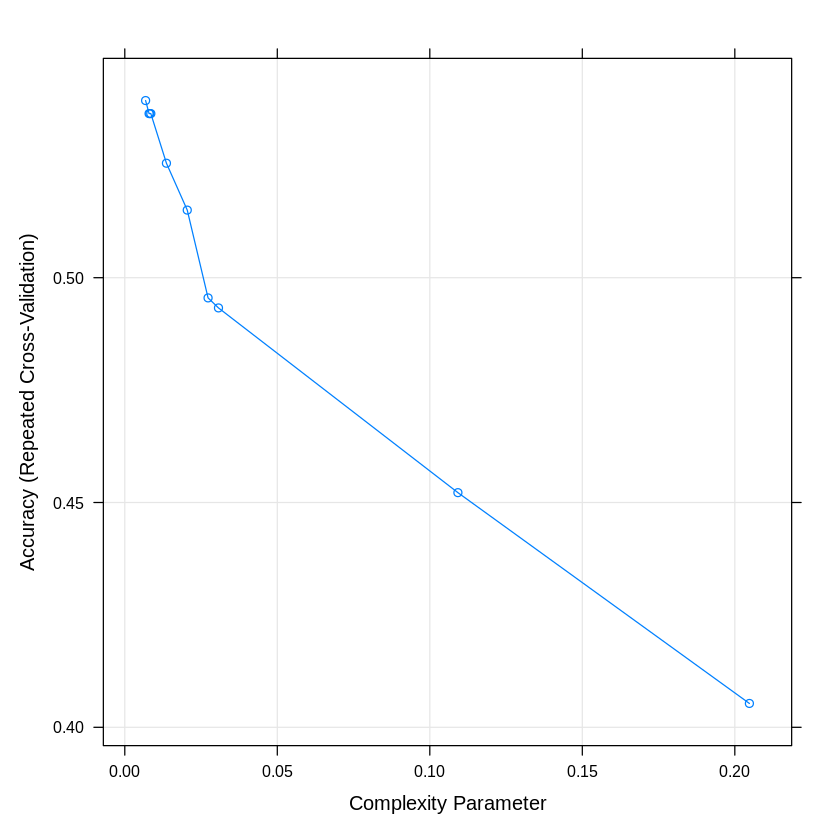

In [ ]:
set.seed(699)
# Attribute Selection:
#attr_subset = Feat_Sel_CHI_SQR(train)
#attr_subset = Feat_Sel_LVQ(train)
#attr_subset = Feat_Sel_RFE(train)
#attr_subset = Feat_Sel_RFI(train
attr_subset = Feat_Sel_IG(train)
train_rpart = attr_subset
train_rpart$class = train$class
test_rpart = test[colnames(attr_subset)]
test_rpart$class = test$class
modelLookup("rpart")
model_rpart <- train(class ~ ., data = train_rpart, method = "rpart", trControl = train_control,
                     tuneLength = 10)
model_rpart
plot(model_rpart)
rpart_test <- predict(model_rpart, newdata = test_rpart)
perf.mea <- confusionMatrix(rpart_test, test$class)
perf.mea
TP.rate = perf.mea$byClass[,1] # Sensitivity
FP.rate = 1 - perf.mea$byClass[,2] # Specificity
Prec = perf.mea$byClass[,3]
Recall = TP.rate
F.meas = 2 * (Prec * Recall) / (Prec + Recall)
print(TP.rate)
print(FP.rate)
print(Prec)
print(Recall)
print(F.meas)
print(ROC(model_rpart, test_rpart))
print(MCC_List(perf.mea))

#Neural Network


Neural Network 

421 samples
  4 predictor
  5 classes: 'average', 'best', 'good', 'low', 'none' 

Pre-processing: centered (4), scaled (4) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 379, 379, 379, 377, 379, 379, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy   Kappa    
   1    0.0    0.5664489  0.4360991
   1    0.1    0.5360454  0.3826431
   1    1.0    0.4580085  0.2707281
   1    2.0    0.4513117  0.2585911
   2    0.0    0.5665129  0.4392873
   2    0.1    0.5666368  0.4282370
   2    1.0    0.5475837  0.3992000
   2    2.0    0.4911616  0.3158617
   3    0.0    0.5627362  0.4340994
   3    0.1    0.5869615  0.4639887
   3    1.0    0.5541241  0.4083624
   3    2.0    0.5014929  0.3311581
   4    0.0    0.5612427  0.4320686
   4    0.1    0.5855177  0.4633861
   4    1.0    0.5570394  0.4128112
   4    2.0    0.5048727  0.3358151
   5    0.0    0.5631210  0.4335766
   5    0.1    0.5851211  0.4641931
   5    1.0 

Confusion Matrix and Statistics

          Reference
Prediction average best good low none
   average      12    3    9   3    2
   best          0   15    5   0    0
   good         17   27   59   1    0
   low          15    0    2  15    6
   none          0    0    0   6   20

Overall Statistics
                                          
               Accuracy : 0.5576          
                 95% CI : (0.4888, 0.6248)
    No Information Rate : 0.3456          
    P-Value [Acc > NIR] : 1.421e-10       
                                          
                  Kappa : 0.4121          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: average Class: best Class: good Class: low
Sensitivity                  0.2727     0.33333      0.7867    0.60000
Specificity                  0.9017     0.97093      0.6831    0.88021
Pos Pred Value               0.4138     0.75000      0.5673    0.39474
Neg P

Class: average    Class: best    Class: good     Class: low    Class: none 
     0.2727273      0.3333333      0.7866667      0.6000000      0.7142857 
Class: average    Class: best    Class: good     Class: low    Class: none 
    0.09826590     0.02906977     0.31690141     0.11979167     0.03174603 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.4137931      0.7500000      0.5673077      0.3947368      0.7692308 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.2727273      0.3333333      0.7866667      0.6000000      0.7142857 
Class: average    Class: best    Class: good     Class: low    Class: none 
     0.3287671      0.4615385      0.6592179      0.4761905      0.7407407 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 0.5389671 0.8268734 0.5488702 0.7694633 0.8352083

[1] 0.2061440 0.4264541 0.4471980 0.4033964 0.7045867

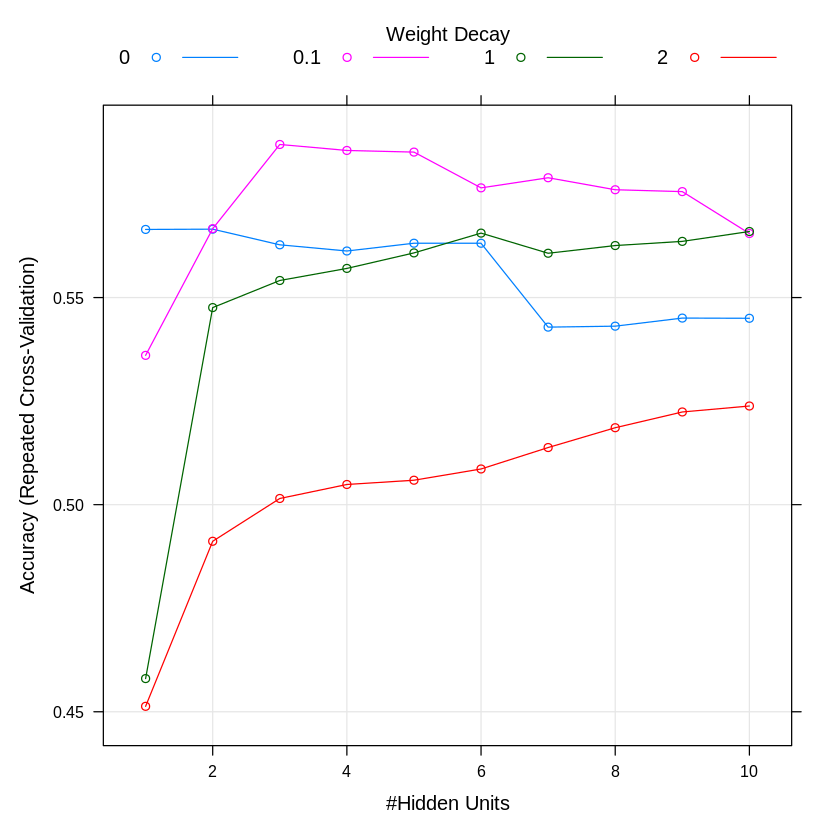

In [ ]:
set.seed(699)
suppressWarnings({
#attr_subset = Feat_Sel_CHI_SQR(train)
attr_subset = Feat_Sel_LVQ(train)
#attr_subset = Feat_Sel_RFE(train)
#attr_subset = Feat_Sel_RFI(train)
#attr_subset = Feat_Sel_IG(train)
train_nnet = attr_subset
train_nnet$class = train$class
test_nnet = test[colnames(attr_subset)]
test_nnet$class = test$class
nnetGrid <- expand.grid(size = 1:10, decay = c(0, .1, 1, 2))
set.seed(31)
model_nnet <- train(class ~ ., data = train_nnet,
                 method = "nnet",
                 preProc = c("center", "scale"),
                 tuneGrid = nnetGrid,
                 trace = FALSE,
                 maxit = 100,
                 MaxNWts = 1000,
                 trControl = train_control)
model_nnet
})
plot(model_nnet)
nnet_test <- predict(model_nnet, test_nnet)
perf.mea <- confusionMatrix(nnet_test, test$class)
perf.mea
TP.rate = perf.mea$byClass[,1] # Sensitivity
FP.rate = 1 - perf.mea$byClass[,2] # Specificity
Prec = perf.mea$byClass[,3]
Recall = TP.rate
F.meas = 2 * (Prec * Recall) / (Prec + Recall)
print(TP.rate)
print(FP.rate)
print(Prec)
print(Recall)
print(F.meas)
ROC(model_nnet, test_nnet)
MCC_List(perf.mea)